<a href="https://colab.research.google.com/github/Ipsi-ta/Sign_LANGUAGE_DETECTION-using-CNN-and-ViT/blob/main/sign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q tensorflow keras keras-cv scikit-learn matplotlib seaborn opencv-python


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
DATASET_PATH = "/content/drive/MyDrive/datasets/sl_dataset"
IMG_SIZE = 224
NUM_CLASSES = 36


In [6]:
X = []
y = []

labels = sorted(os.listdir(DATASET_PATH))
label_dict = {label:i for i, label in enumerate(labels)}

for label in labels:
    folder_path = os.path.join(DATASET_PATH, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        y.append(label_dict[label])

X = np.array(X) / 255.0
y = to_categorical(y, NUM_CLASSES)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

cnn_model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,254,820 (84.90 MB)

 Trainable params: 22,254,372 (84.89 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
cnn_history = cnn_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - accuracy: 0.3903 - loss: 2.7941 - val_accuracy: 0.0446 - val_loss: 3.5611
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.8430 - loss: 0.5490 - val_accuracy: 0.0446 - val_loss: 3.7377
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.9238 - loss: 0.2669 - val_accuracy: 0.0891 - val_loss: 3.7136
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.9465 - loss: 0.1670 - val_accuracy: 0.0891 - val_loss: 3.8192
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 267s 4s/step - accuracy: 0.9586 - loss: 0.1355 - val_accuracy: 0.1040 - val_loss: 3.4193
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - accuracy: 0.9611 - loss: 0.1110 - val_accuracy: 0.2376 - val_loss: 2.7532
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.9597 - loss: 0.1039 - val_accuracy: 0.5099 - val_loss: 1.5677
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - accuracy: 0.9721 - loss: 0.0932 - val_accuracy: 0.9208 - v

In [12]:
y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred))


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 929ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       1.00      1.00      1.00        14
           2       0.88      1.00      0.93        14
           3       1.00      1.00      1.00        14
           4       0.93      1.00      0.97        14
           5       1.00      1.00      1.00        14
           6       0.92      0.86      0.89        14
           7       1.00      0.93      0.96        14
           8       0.92      0.86      0.89        14
           9       0.93      1.00      0.97        14
          10       1.00      1.00      1.00        14
          11       1.00      0.93      0.96        14
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        14
          16       1.00      1.00      

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 933ms/step


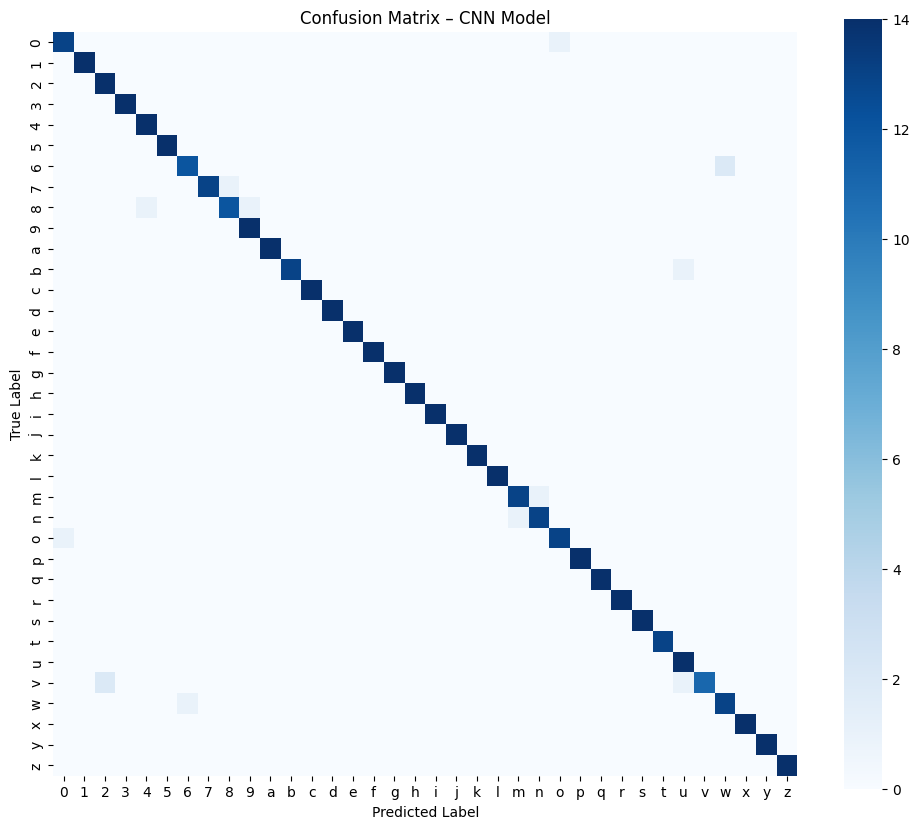

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert predictions and true labels
y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    square=True
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – CNN Model")
plt.show()


In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 929ms/step


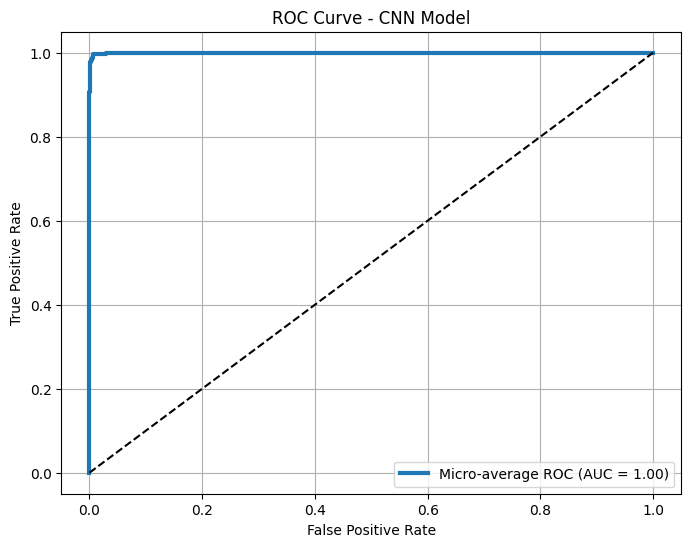

In [15]:
# Get CNN prediction probabilities
y_score_cnn = cnn_model.predict(X_test)

# True labels (already one-hot)
y_true = y_test

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score_cnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_true.ravel(), y_score_cnn.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
    linewidth=3,
)

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CNN Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [16]:
!pip install -q tensorflow scikit-learn opencv-python matplotlib seaborn



In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models


In [18]:
class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.projection = layers.Dense(embed_dim)

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [tf.shape(images)[0], -1, patch_dims])
        return self.projection(patches)


In [20]:
def transformer_block(x, num_heads, embed_dim, mlp_dim):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    mlp = layers.Dense(mlp_dim, activation="gelu")(x)
    mlp = layers.Dense(embed_dim)(mlp)
    x = layers.Add()([x, mlp])
    return layers.LayerNormalization()(x)


In [21]:
def build_light_vit():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = PatchEmbedding(16, 64)(inputs)   # reduced embedding

    for _ in range(3):                   # fewer layers
        x = transformer_block(x, num_heads=2, embed_dim=64, mlp_dim=128)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return models.Model(inputs, outputs)



In [23]:
vit_model = build_light_vit()   # or build_vit() if you used that name

vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

vit_model.summary()

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
vit_model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=40,
    validation_data=(X_test, y_test)
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, None, 64)  │     49,216 │ input_layer_1[0]… │
│ (PatchEmbedding)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     33,216 │ patch_embedding[… │
│ (MultiHeadAttentio… │                   │            │ patch_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 64)  │          0 │ patch_embedding[… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 64)  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None, 64)  │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     33,216 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, None, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, None, 64)  │      8,256 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     33,216 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, None, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten

 Total params: 212,324 (829.39 KB)

 Trainable params: 212,324 (829.39 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 79s 545ms/step - accuracy: 0.0367 - loss: 3.6823 - val_accuracy: 0.0537 - val_loss: 3.5419
Epoch 2/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 67s 530ms/step - accuracy: 0.0377 - loss: 3.5440 - val_accuracy: 0.0557 - val_loss: 3.4811
Epoch 3/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 65s 515ms/step - accuracy: 0.0624 - loss: 3.4933 - val_accuracy: 0.0596 - val_loss: 3.4139
Epoch 4/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 67s 528ms/step - accuracy: 0.0613 - loss: 3.4274 - val_accuracy: 0.0775 - val_loss: 3.2664
Epoch 5/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 65s 515ms/step - accuracy: 0.0764 - loss: 3.3105 - val_accuracy: 0.0954 - val_loss: 3.1122
Epoch 6/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 70s 552ms/step - accuracy: 0.0657 - loss: 3.2049 - val_accuracy: 0.1113 - val_loss: 3.0211
Epoch 7/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 67s 529ms/step - accuracy: 0.0701 - loss: 3.1984 - val_accuracy: 0.1014 - val_loss: 2.9724
Epoch 8/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 65s 515ms/step - accuracy: 0.0644 - loss: 3

In [24]:
import os

DATASET_PATH = "/content/drive/MyDrive/datasets/sl_dataset"

# Read folder names as labels
labels = sorted(os.listdir(DATASET_PATH))

print("Class Labels:")
print(labels)
print("Number of classes:", len(labels))


Class Labels:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Number of classes: 36


In [25]:
print("Example label mapping:")
for i, lbl in enumerate(labels[:10]):
    print(i, "→", lbl)


Example label mapping:
0 → 0
1 → 1
2 → 2
3 → 3
4 → 4
5 → 5
6 → 6
7 → 7
8 → 8
9 → 9


In [32]:
import os

print(os.listdir())


['.config', 'drive', 'sample_data']


In [34]:
from IPython.display import Javascript, display
from google.colab.output import eval_js
import base64

def take_photo():
    js = Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.border = '2px solid black';

            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            await new Promise(resolve => setTimeout(resolve, 3000));

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            stream.getTracks().forEach(track => track.stop());
            div.remove();

            return canvas.toDataURL('image/jpeg');
        }
        takePhoto();
    ''')
    display(js)
    data = eval_js('takePhoto()')
    return base64.b64decode(data.split(',')[1])


In [98]:
import os

image_data = take_photo()

with open("live_sign.jpg", "wb") as f:
    f.write(image_data)

print("Image saved:", os.path.exists("live_sign.jpg"))


<IPython.core.display.Javascript object>

Image saved: True


In [99]:
import cv2
import numpy as np

img = cv2.imread("live_sign.jpg")

if img is None:
    raise ValueError("Image not found. Please capture again.")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img.astype("float32") / 255.0
img = np.expand_dims(img, axis=0)

print("Input shape:", img.shape)

prediction = cnn_model.predict(img)
predicted_label = labels[np.argmax(prediction)]
confidence = np.max(prediction) * 100

print(f"Predicted Sign: {predicted_label} ({confidence:.2f}%)")


Input shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted Sign: j (94.03%)
